# Time Series analysis of HTTP Bro Log

Time Series is a good techqiue that we can use for Cybersecurity data since all the actions in cyber is related to the time.

In [ ]:
%matplotlib notebook
import pandas as pd


## Data input

In [ ]:
http_df = pd.read_csv("resources/http.log.zip", header=None, sep="\t", 
                      names=['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'trans_depth', 'method', 'host', 'uri', 'referrer', 
                             'user_agent', 'request_body_len', 'response_body_len', 'status_code', 'status_msg', 'info_code', 'info_msg', 'filename', 'tags', 
                             'username', 'password', 'proxied', 'orig_fuids', 'orig_mime_types', 'resp_fuids', 'resp_mime_types', 'sample']) 
#resources from http://www.secrepo.com/Datasets%20Description/Network/http.html
http_df.head()

## Timestamp

In [ ]:
#clean up the timestamp column ts
from datetime import datetime
http_df['ts'] = [datetime.fromtimestamp(float(date)) for date in http_df['ts'].values]
http_df = http_df.set_index('ts')
http_df.head()
# code provided by https://github.com/sooshie/Security-Data-Analysis/blob/master/Lab_2/Lab_2-Solutions.ipynb

## Graphing time series data

We focus on two cols, which are request_body_len and response_body_len

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (16.0, 5.0)
df = http_df[['request_body_len','response_body_len']]
df.plot()
df.head
np.unique(df['request_body_len'])
# request_body_len means Actual uncompressed content size of the data transferred from the client
# response_body_len means Actual uncompressed content size of the data transferred from the server  
# code provided by https://github.com/sooshie/Security-Data-Analysis/blob/master/Lab_2/Lab_2-Solutions.ipynb

The figure above shows the actual umcompressed content size of data from the client and server at the end of month. You can see that blue line is very tiny which means comparing to response, it has very small amount of data size transferred.

## Resamping data

In [ ]:
%matplotlib notebook
resamp = df.resample("M", how=['mean', 'count', 'sum']) #"M" means month end frequency
resamp.plot(subplots=True)
# code provided by https://github.com/sooshie/Security-Data-Analysis/blob/master/Lab_2/Lab_2-Solutions.ipynb

The graph shows that the data that resampled by mean, number of count, total data size at the end of month

In [ ]:
resamp.plot()

Times Series Model-- ARIMA(p,d,q)
https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

using ACF and PACF to determine p and q.
https://onlinecourses.science.psu.edu/stat510/node/62/

ACF and PACF
https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

Code for ACF and PACF
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

Python code for time series
https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

## Try modelling the count of response_body_len

ARIMA model is combined by two models which are Autoregressive Model(AR) and Moving Average Model(MA)
To determine the order of the model, i.e ARMA(p,d,q), p and q are the orders of the model, we need to plot the autocorrelation function plot(acf) to determine q, and partial autocorrelation function(pacf) plot to get p's value. d is differencing, in statistics is a transformation applied to time-series data in order to make it stationary. 

Since the big value of data, we need to take logarithm to our data and difference the data to make it stationary.

In [ ]:
resamp['response_count_log']=resamp['response_body_len']['count'].apply(np.log) 
resamp['response_count_log_diff'] = resamp['response_count_log'] - resamp['response_count_log'].shift()
resamp1 = resamp['response_count_log_diff'][1:]
resamp1


In [ ]:
%matplotlib notebook
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(resamp1, nlags=20)
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(resamp1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(resamp1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
lag_pacf = pacf(resamp1, nlags=34, method='ols')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(resamp1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(resamp1)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

By the acf plot, we can get q's value. Q's value depends on how many lags that are beyond the boundaries in the first time. 
According to this plot, we can get that lag 1 is above the boundaries, so we can say that q is equal to 1.

Similarly, we can use pacf to determine the p value by the same way. 

By the plot, we can get p is equal to 1.

Therefore we could say that it is a ARIMA model with p=1, q=1, d=1

## Fit model and predict

### Set Train and Test data

we have 37 months of data, we set first 34 months as training data, and last 3 months as test data.

In [ ]:
#train data
train = resamp1[0:33]
test = resamp1[33:36]
train

In [ ]:
# ARIMA
from statsmodels.tsa.arima_model import ARIMA
# fit model p=1, q=1,d=1
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit(disp=False)
# test the data
yhat = model_fit.predict(len(train),(len(resamp1)))
print(yhat)
new = train.append(yhat)
new_cumsum = new.cumsum()
new_cum = pd.Series(resamp['response_count_log'][0], index= resamp['response_count_log'].index)
new_cum = new_cum.add(new_cumsum,fill_value=0)
new_cum[37]= new_cum[37] + resamp['response_count_log'][0]

np.exp(new_cum)[-4:]



Here is what we predict for August 2014.

## ARIMA(1,1,1)
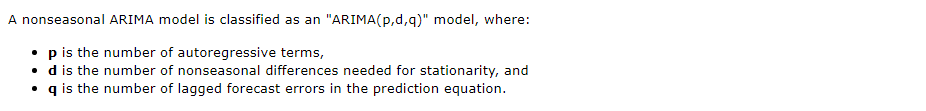
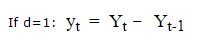